In [ ]:
import numpy as np
import pandas as pd
from time import time
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [ ]:
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Functions

In [ ]:
def draw_graph(rules, rules_to_show):

  G1 = nx.DiGraph()

  color_map=[]
  N = 50
  colors = np.random.rand(N)
  strs = ['R' + str(i) for i in range(rules_to_show)]

  for i in range (rules_to_show):
    G1.add_nodes_from(["R" + str(i)])

    for a in rules.iloc[i]['antecedents']:
        G1.add_nodes_from([a])
        G1.add_edge(a, "R" + str(i), color=colors[i] , weight=2)

    for c in rules.iloc[i]['consequents']:
            G1.add_nodes_from([c])
            G1.add_edge("R" + str(i), c, color=colors[i],  weight=2)

  for node in G1:
       found_a_string = False
       for item in strs:
           if node==item:
                found_a_string = True
       if found_a_string:
            color_map.append('yellow')
       else:
            color_map.append('green')



  edges = G1.edges()
  colors = [G1[u][v]['color'] for u,v in edges]
  weights = [G1[u][v]['weight'] for u,v in edges]

  pos = nx.spring_layout(G1, k=16, scale=1)
  nx.draw(G1, pos, node_color = color_map, edge_color=colors, width=weights, font_size=16, with_labels=False)

  for p in pos:
           pos[p][1] += 0.1
  nx.draw_networkx_labels(G1, pos)
  plt.show()

In [ ]:
def Run(method, transactions, n=5, k=20, a=0.01, b=0.1):
    
    times = []
    items = []
    for min_sup in np.linspace(a, b, k):
        T = []
        for _ in range(n):
            start = time()
            frq_items = method(transactions, min_sup)
            end = time()
            T.append(end - start)

        times.append(np.mean(T))
        items.append(len(frq_items))

    return times, items

# 1) Load Dataset

## 1.1 Get Dataset

In [ ]:
! wget -P data/ http://fimi.uantwerpen.be/data/retail.dat

--2023-11-25 20:15:55--  http://fimi.uantwerpen.be/data/retail.dat
Resolving fimi.uantwerpen.be (fimi.uantwerpen.be)... 143.129.69.1
Connecting to fimi.uantwerpen.be (fimi.uantwerpen.be)|143.129.69.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4167490 (4.0M)
Saving to: ‘retail.dat’

retail.dat          100%[===================>]   3.97M  2.07MB/s    in 1.9s    

2023-11-25 20:15:58 (2.07 MB/s) - ‘retail.dat’ saved [4167490/4167490]



## 1.2 Read Dat File

In [ ]:
datfile = open('data/retail.dat', 'r')

retails = []

for line in datfile.readlines():
  transaction = line.strip().split(' ')
  retails.append(np.array(transaction).astype(int))

In [ ]:
len(retails)

88162

## 1.3 Transaction Encoding

In [ ]:
encoder = TransactionEncoder()
retails_encoded = encoder.fit_transform(retails, sparse=True)

## 1.4 Convert to DataFrame

In [ ]:
df = pd.DataFrame.sparse.from_spmatrix(retails_encoded, columns=encoder.columns_)

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,16460,16461,16462,16463,16464,16465,16466,16467,16468,16469
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 1.5 Items Distribution

In [ ]:
top10items = df.sum(axis=0).sort_values(ascending=False)[:10]

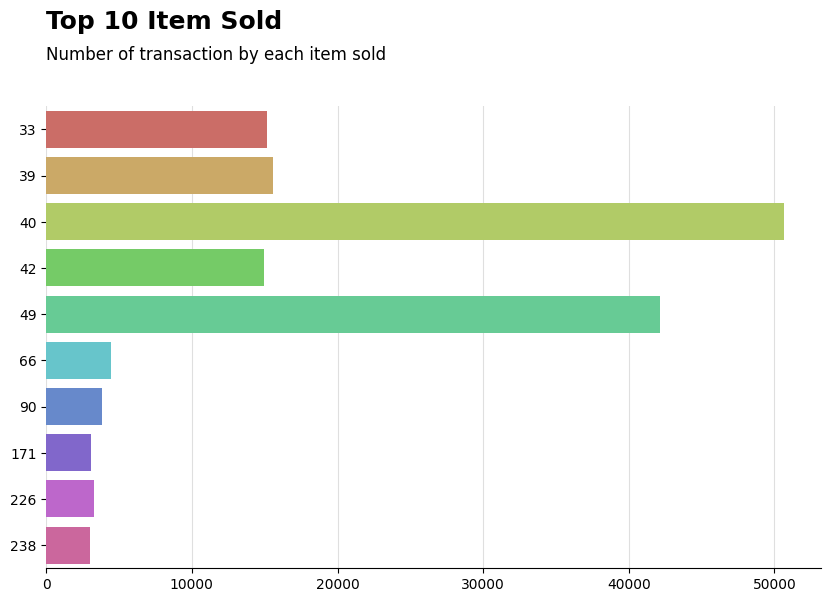

In [ ]:
fig, prod = plt.subplots(figsize=(10,6))

prod = sns.barplot(
    x=top10items, 
    y=top10items.index + 1, 
    orient='h', 
    palette='hls'
)

prod.set_title(
    "Top 10 Item Sold", 
    loc='left', 
    y=1.15, 
    fontweight='bold', 
    size='18'
)

prod.text(
    0, 1.10, 
    "Number of transaction by each item sold", 
    transform= prod.transAxes, size=12
)

for i in ['left', 'top', 'right']:
    prod.spines[i].set_visible(False)

prod.grid(axis='x', alpha=0.4)
prod.set_axisbelow(True)

prod.set_xlabel(None)
prod.set_ylabel(None)

plt.show();

# 2) Frequent Pattern Mining

## 2.1 Apriori

### 2.1.1 MLXTEND Library

#### 2.1.1.1 Build Model

In [ ]:
frq_items = apriori(df, min_support=0.1)

In [ ]:
frq_items

,support,itemsets
0,0.172036,(32)
1,0.176902,(38)
2,0.574794,(39)
3,0.169517,(41)
4,0.477927,(48)
5,0.117341,"(38, 39)"
6,0.129466,"(41, 39)"
7,0.330551,"(48, 39)"
8,0.102289,"(48, 41)"


#### 2.1.1.2 Collecting Rules

In [ ]:
rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])

In [ ]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2,(41),(39),0.169517,0.574794,0.129466,0.763734,1.328708,0.032029,1.799689,0.297886
4,(48),(39),0.477927,0.574794,0.330551,0.691634,1.203273,0.055841,1.378900,0.323581
0,(38),(39),0.176902,0.574794,0.117341,0.663311,1.153998,0.015659,1.262904,0.162128
7,(41),(48),0.169517,0.477927,0.102289,0.603413,1.262562,0.021272,1.316413,0.250408
5,(39),(48),0.574794,0.477927,0.330551,0.575076,1.203273,0.055841,1.228628,0.397297
3,(39),(41),0.574794,0.169517,0.129466,0.225239,1.328708,0.032029,1.071921,0.581811
6,(48),(41),0.477927,0.169517,0.102289,0.214026,1.262562,0.021272,1.056629,0.398335
1,(39),(38),0.574794,0.176902,0.117341,0.204144,1.153998,0.015659,1.034230,0.313841


#### 2.1.1.3 Drawing Rules

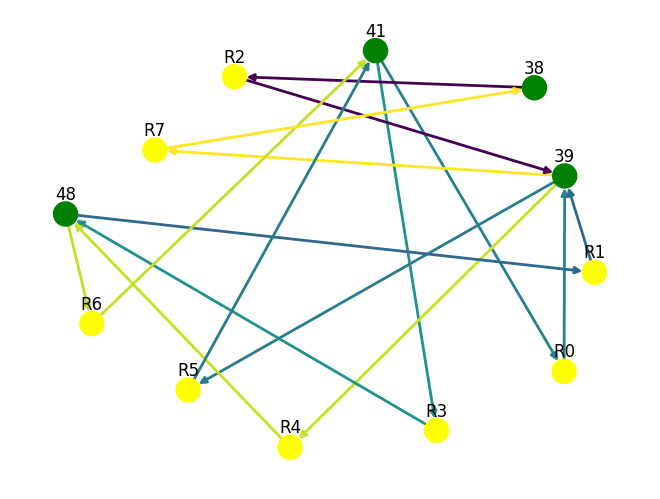

In [ ]:
draw_graph(rules, 8)

#### 2.1.1.4 Scatter Plot

Text(0, 0.5, 'confidence')

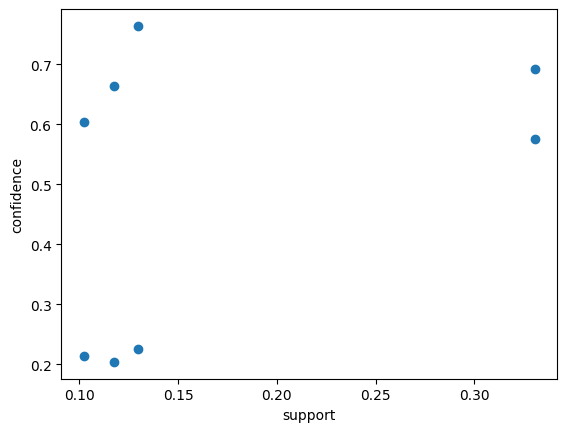

In [ ]:
plt.scatter(rules['support'], rules['confidence'])
plt.xlabel('support')
plt.ylabel('confidence')

#### 2.1.1.5 Min-support Analysis

In [ ]:
mlx_ap_time, mlx_ap_item = Run(apriori, df, n=5, k=20)

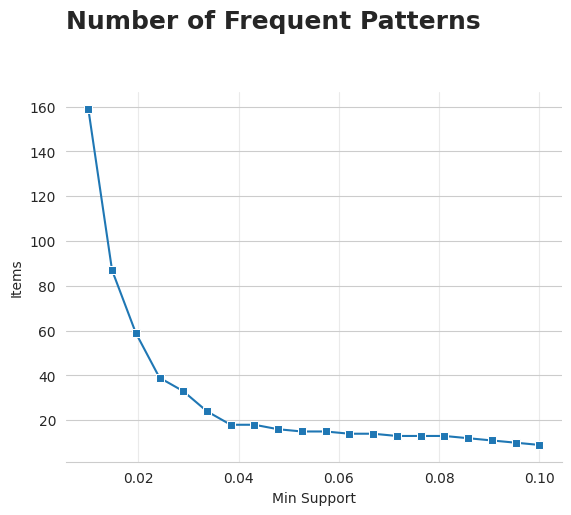

In [ ]:
sns.set_style("whitegrid")
items = sns.lineplot(x=np.linspace(0.01, 0.1, 20), y=mlx_ap_item, marker='s', palette='hls')
items.set_title("Number of Frequent Patterns", loc='left', y=1.15, fontweight='bold', size='18')

for i in ['left', 'top', 'right']:
    items.spines[i].set_visible(False)

items.grid(axis='x', alpha=0.4)
items.set_axisbelow(True)

items.set_xlabel('Min Support')
items.set_ylabel('Items')

plt.show();

### 2.1.2 Implementation

In [ ]:
from FPMining import Apriori

In [ ]:
ap = Apriori()

In [ ]:
L = ap.fit(retails, min_sup=0.1)

In [ ]:
L

[{'Itemset': [[32], [38], [39], [41], [48]],
  'Support': [15167, 15596, 50675, 14945, 42135]},
 {'Itemset': [[38, 39], [41, 39], [48, 39], [48, 41]],
  'Support': [10345, 11414, 29142, 9018]}]

#### Min-support Analysis

In [ ]:
ap_time, _ = Run(ap.fit, retails, n=5, k=20)

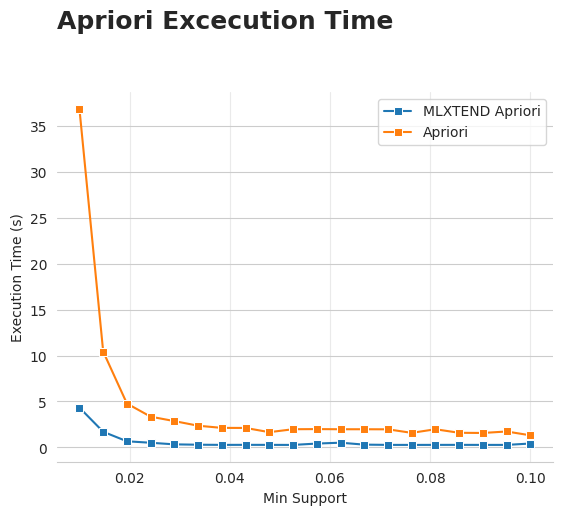

In [ ]:
sns.set_style("whitegrid")
plot = sns.lineplot(x=np.linspace(0.01, 0.1, 20), y=mlx_ap_time, marker='s', palette='hls', label='MLXTEND Apriori')
plot = sns.lineplot(x=np.linspace(0.01, 0.1, 20), y=ap_time, marker='s', palette='hls', label='Apriori')
plot.set_title("Apriori Excecution Time", loc='left', y=1.15, fontweight='bold', size='18')

for i in ['left', 'top', 'right']:
    plot.spines[i].set_visible(False)

plot.grid(axis='x', alpha=0.4)
plot.set_axisbelow(True)

plot.set_xlabel('Min Support')
plot.set_ylabel('Execution Time (s)')

plt.show();

## 2.2 FP Growth

### 2.2.1 MLXTEND

#### 2.2.1.1 Buil Model

In [ ]:
frq_items = fpgrowth(df, min_support=0.1)

In [ ]:
frq_items

,support,itemsets
0,0.172036,(32)
1,0.574794,(39)
2,0.176902,(38)
3,0.169517,(41)
4,0.477927,(48)
5,0.117341,"(38, 39)"
6,0.129466,"(41, 39)"
7,0.102289,"(48, 41)"
8,0.330551,"(48, 39)"


#### 2.2.1.2 Collecting Rules

In [ ]:
rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])

In [ ]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2,(41),(39),0.169517,0.574794,0.129466,0.763734,1.328708,0.032029,1.799689,0.297886
6,(48),(39),0.477927,0.574794,0.330551,0.691634,1.203273,0.055841,1.378900,0.323581
0,(38),(39),0.176902,0.574794,0.117341,0.663311,1.153998,0.015659,1.262904,0.162128
5,(41),(48),0.169517,0.477927,0.102289,0.603413,1.262562,0.021272,1.316413,0.250408
7,(39),(48),0.574794,0.477927,0.330551,0.575076,1.203273,0.055841,1.228628,0.397297
3,(39),(41),0.574794,0.169517,0.129466,0.225239,1.328708,0.032029,1.071921,0.581811
4,(48),(41),0.477927,0.169517,0.102289,0.214026,1.262562,0.021272,1.056629,0.398335
1,(39),(38),0.574794,0.176902,0.117341,0.204144,1.153998,0.015659,1.034230,0.313841


### 2.2.1.3 Drawing Rules

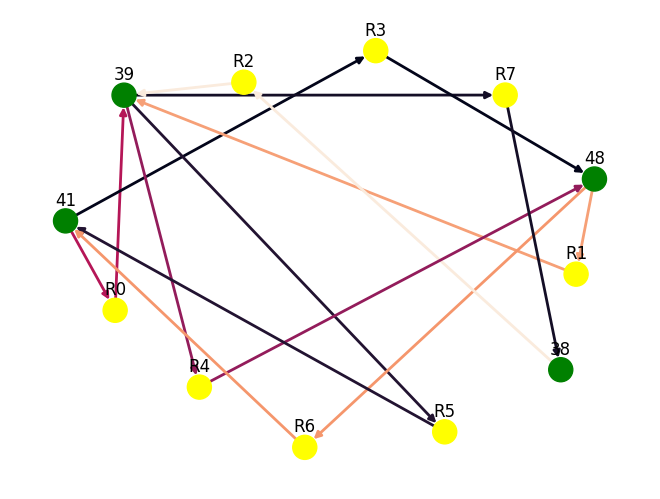

In [ ]:
draw_graph(rules, 8)

### 2.2.1.4 Scatter Plot

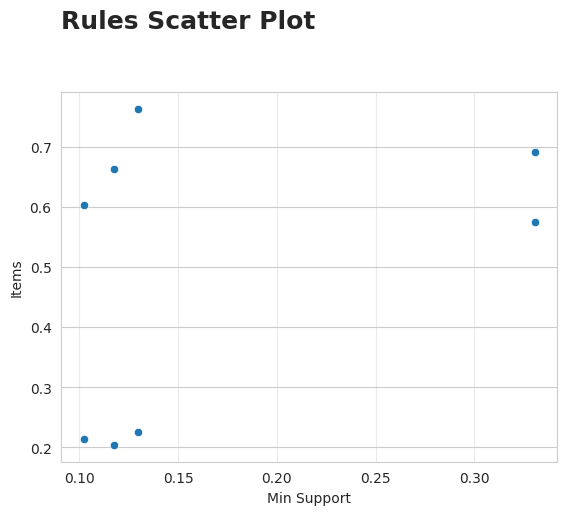

In [ ]:
plot = sns.scatterplot(x=rules['support'], y=rules['confidence'])
plot.set_title(
    "Rules Scatter Plot", 
    loc='left', 
    y=1.15, 
    fontweight='bold', 
    size='18'
)

plot.grid(axis='x', alpha=0.4)
plot.set_axisbelow(True)

plot.set_xlabel('Min Support')
plot.set_ylabel('Items')
plt.show()

### 2.2.1.5 Min-support Analysis

In [ ]:
mlx_fp_time, mlx_fp_item = Run(fpgrowth, df, n=5, k=20)

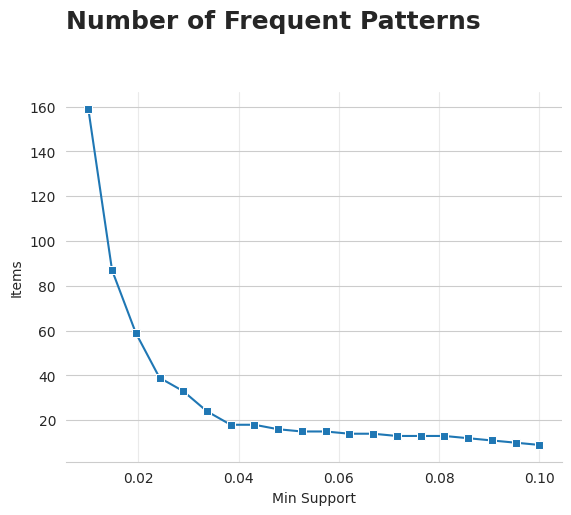

In [ ]:
sns.set_style("whitegrid")
items = sns.lineplot(
    x=np.linspace(0.01, 0.1, 20), 
    y=mlx_fp_item, 
    marker='s', 
    palette='hls'
)

items.set_title(
    "Number of Frequent Patterns", 
    loc='left', 
    y=1.15, 
    fontweight='bold', 
    size='18'
)

for i in ['left', 'top', 'right']:
    items.spines[i].set_visible(False)

items.grid(axis='x', alpha=0.4)
items.set_axisbelow(True)

items.set_xlabel('Min Support')
items.set_ylabel('Items')

plt.show();

### 2.2.2 Implementation

In [ ]:
from FPMining import FPGrowth

In [ ]:
fp = FPGrowth()

In [ ]:
L = fp.fit(retails, min_sup=0.1)

In [ ]:
L

{(41,): 14945,
 (48, 41): 9018,
 (38,): 15596,
 (39, 48): 29142,
 (39,): 50675,
 (39, 41): 11414,
 (48,): 42135,
 (32,): 15167,
 (39, 38): 10345}

In [ ]:
fp_time, _ = Run(fp.fit, retails, n=5, k=20)

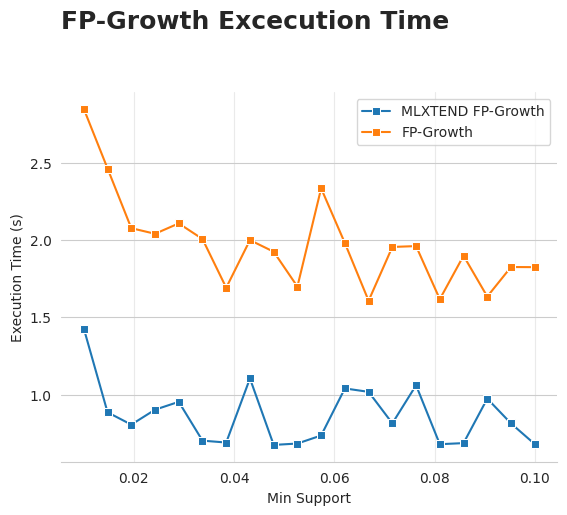

In [ ]:
sns.set_style("whitegrid")
plot = sns.lineplot(
    x=np.linspace(0.01, 0.1, 20), 
    y=mlx_fp_time, 
    marker='s', 
    palette='hls', 
    label='MLXTEND FP-Growth'
)

plot = sns.lineplot(
    x=np.linspace(0.01, 0.1, 20), 
    y=fp_time, 
    marker='s', 
    palette='hls', 
    label='FP-Growth'
)

plot.set_title(
    "FP-Growth Excecution Time", 
    loc='left', 
    y=1.15, 
    fontweight='bold', 
    size='18'
)

for i in ['left', 'top', 'right']:
    plot.spines[i].set_visible(False)

plot.grid(axis='x', alpha=0.4)
plot.set_axisbelow(True)

plot.set_xlabel('Min Support')
plot.set_ylabel('Execution Time (s)')

plt.show();

## 2.3 Execution Time Comparison

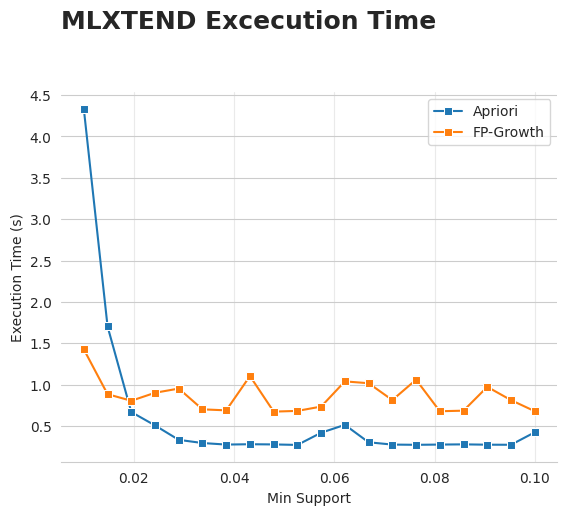

In [ ]:
sns.set_style("whitegrid")
plot = sns.lineplot(x=np.linspace(0.01, 0.1, 20), y=mlx_ap_time, marker='s', palette='hls', label='Apriori')
plot = sns.lineplot(x=np.linspace(0.01, 0.1, 20), y=mlx_fp_time, marker='s', palette='hls', label='FP-Growth')
plot.set_title("MLXTEND Excecution Time", loc='left', y=1.15, fontweight='bold', size='18')

for i in ['left', 'top', 'right']:
    plot.spines[i].set_visible(False)

plot.grid(axis='x', alpha=0.4)
plot.set_axisbelow(True)

plot.set_xlabel('Min Support')
plot.set_ylabel('Execution Time (s)')

plt.show();

In [ ]:
mlx_ap_time2, _ = Run(apriori, df, n=5, k=5, a=0.005, b=0.01)
mlx_fp_time2, _ = Run(fpgrowth, df, n=5, k=5, a=0.005, b=0.01)

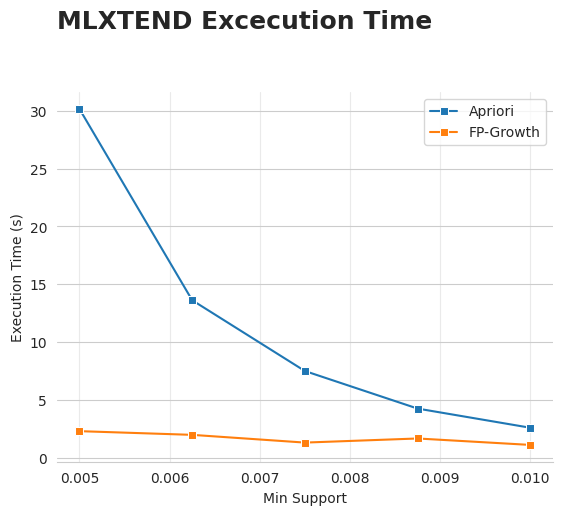

In [ ]:
sns.set_style("whitegrid")
plot = sns.lineplot(
    x=np.linspace(0.005, 0.01, 5), 
    y=mlx_ap_time2, 
    marker='s', 
    palette='hls', 
    label='Apriori'
)
plot = sns.lineplot(
    x=np.linspace(0.005, 0.01, 5), 
    y=mlx_fp_time2, 
    marker='s', 
    palette='hls', 
    label='FP-Growth'
)

plot.set_title(
    "MLXTEND Excecution Time", 
    loc='left', 
    y=1.15, 
    fontweight='bold', 
    size='18'
)

for i in ['left', 'top', 'right']:
    plot.spines[i].set_visible(False)

plot.grid(axis='x', alpha=0.4)
plot.set_axisbelow(True)

plot.set_xlabel('Min Support')
plot.set_ylabel('Execution Time (s)')

plt.show();

# 2.3 ECLAT

In [ ]:
from FPMining import ECLAT

In [ ]:
eclat = ECLAT()

In [ ]:
L = eclat.fit(retails, min_sup=0.1)

In [ ]:
L

[{(32,): 15167},
 {(38,): 15596},
 {(39,): 50675},
 {(41,): 14945},
 {(48,): 42135},
 {(38, 39): 10345},
 {(39, 41): 11414},
 {(39, 48): 29142},
 {(41, 48): 9018}]

In [ ]:
eclat_time, _ = Run(eclat.fit, retails, n=5, k=20)

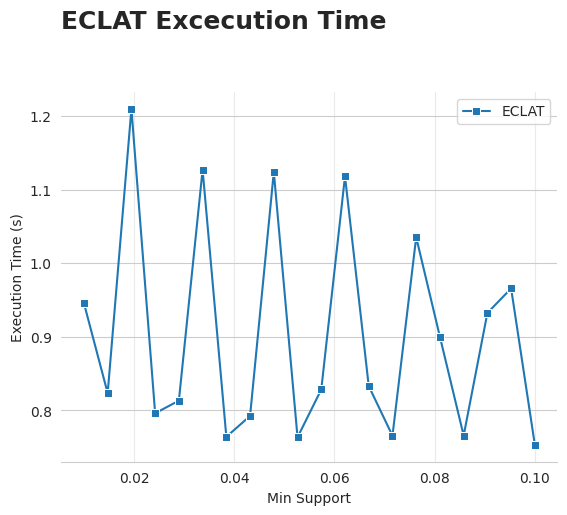

In [ ]:
sns.set_style("whitegrid")
plot = sns.lineplot(
    x=np.linspace(0.01, 0.1, 20), 
    y=eclat_time, 
    marker='s', 
    palette='hls', 
    label='ECLAT'
)

plot.set_title(
    "ECLAT Excecution Time", 
    loc='left', 
    y=1.15, 
    fontweight='bold', 
    size='18'
)

for i in ['left', 'top', 'right']:
    plot.spines[i].set_visible(False)

plot.grid(axis='x', alpha=0.4)
plot.set_axisbelow(True)

plot.set_xlabel('Min Support')
plot.set_ylabel('Execution Time (s)')

plt.show();

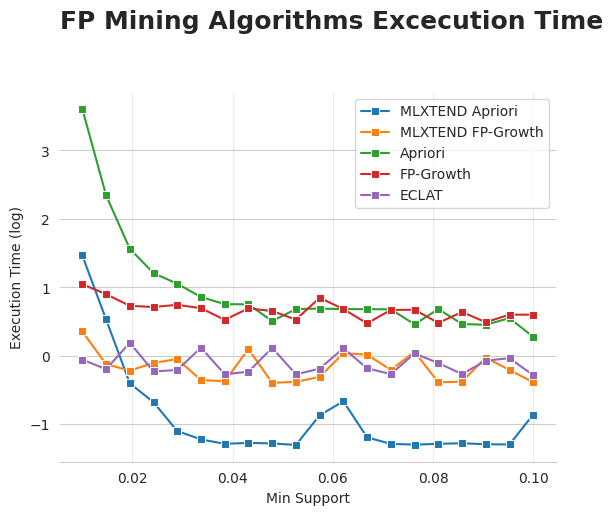

In [ ]:
sns.set_style("whitegrid")
plot = sns.lineplot(
    x=np.linspace(0.01, 0.1, 20), 
    y=np.log(mlx_ap_time), 
    marker='s', 
    palette='hls', 
    label='MLXTEND Apriori'
)
plot = sns.lineplot(
    x=np.linspace(0.01, 0.1, 20), 
    y=np.log(mlx_fp_time), 
    marker='s', 
    palette='hls', 
    label='MLXTEND FP-Growth'
)
plot = sns.lineplot(
    x=np.linspace(0.01, 0.1, 20), 
    y=np.log(ap_time), 
    marker='s', 
    palette='hls', 
    label='Apriori'
)
plot = sns.lineplot(
    x=np.linspace(0.01, 0.1, 20), 
    y=np.log(fp_time), 
    marker='s', 
    palette='hls', 
    label='FP-Growth'
)
plot = sns.lineplot(
    x=np.linspace(0.01, 0.1, 20), 
    y=np.log(eclat_time), 
    marker='s', 
    palette='hls', 
    label='ECLAT'
)

plot.set_title(
    "FP Mining Algorithms Excecution Time", 
    loc='left', 
    y=1.15, 
    fontweight='bold', 
    size='18'
)

for i in ['left', 'top', 'right']:
    plot.spines[i].set_visible(False)

plot.grid(axis='x', alpha=0.4)
plot.set_axisbelow(True)

plot.set_xlabel('Min Support')
plot.set_ylabel('Execution Time (log)')

plt.show();

# 3) Sampling

In [ ]:
df_60 = df.sample(frac=0.60)

In [ ]:
len(df_60)

52897

## 3.1 Apriori

In [ ]:
frq_items_60 = apriori(df_60, min_support=0.1)

In [ ]:
frq_items_60

,support,itemsets
0,0.171409,(32)
1,0.174055,(38)
2,0.574532,(39)
3,0.171106,(41)
4,0.477418,(48)
5,0.114638,"(38, 39)"
6,0.130159,"(41, 39)"
7,0.331153,"(48, 39)"
8,0.103314,"(48, 41)"


In [ ]:
rules_60 = association_rules(frq_items_60, metric ="lift", min_threshold = 1)
rules_60 = rules_60.sort_values(['confidence', 'lift'], ascending =[False, False])

In [ ]:
rules_60

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2,(41),(39),0.171106,0.574532,0.130159,0.760689,1.324017,0.031853,1.777892,0.295240
4,(48),(39),0.477418,0.574532,0.331153,0.693633,1.207301,0.056861,1.388752,0.328573
0,(38),(39),0.174055,0.574532,0.114638,0.658629,1.146376,0.014638,1.246353,0.154594
7,(41),(48),0.171106,0.477418,0.103314,0.603801,1.264720,0.021625,1.318987,0.252519
5,(39),(48),0.574532,0.477418,0.331153,0.576388,1.207301,0.056861,1.233632,0.403570
3,(39),(41),0.574532,0.171106,0.130159,0.226547,1.324017,0.031853,1.071680,0.575184
6,(48),(41),0.477418,0.171106,0.103314,0.216401,1.264720,0.021625,1.057804,0.400533
1,(39),(38),0.574532,0.174055,0.114638,0.199533,1.146376,0.014638,1.031828,0.300107


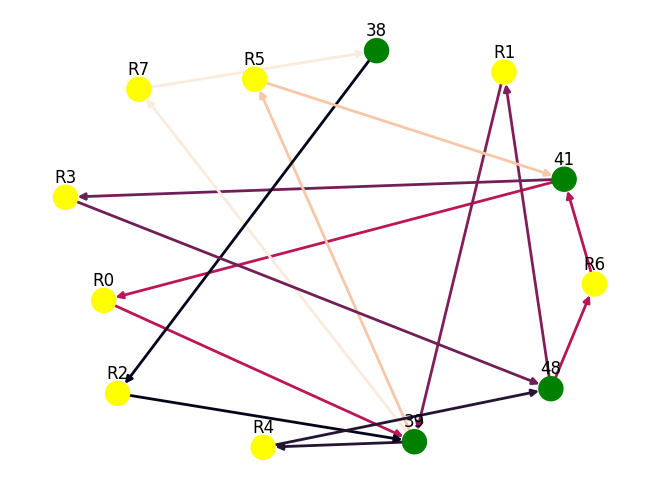

In [ ]:
draw_graph(rules_60, 8)

Text(0, 0.5, 'confidence')

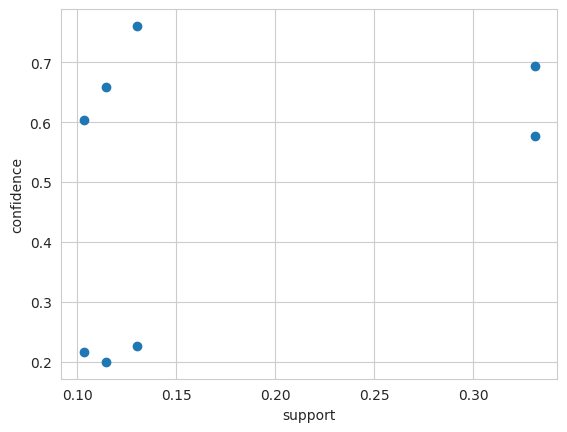

In [ ]:
plt.scatter(rules_60['support'], rules_60['confidence'])
plt.xlabel('support')
plt.ylabel('confidence')

In [ ]:
mlx_ap_time_60, mlx_ap_item_60 = Run(apriori, df_60, n=5, k=20)
mlx_fp_time_60, mlx_fp_item_60 = Run(fpgrowth, df_60, n=5, k=20)

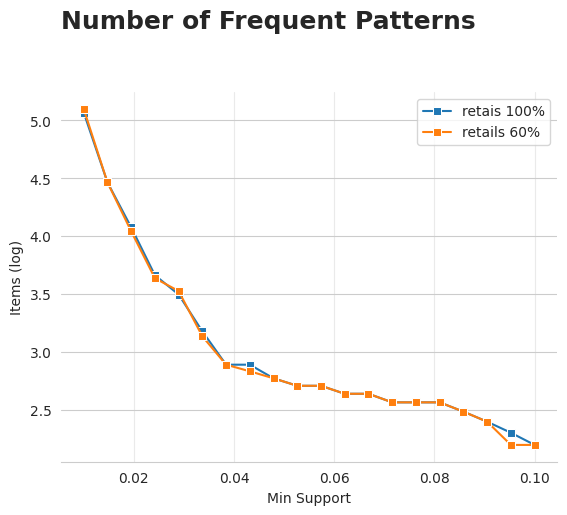

In [ ]:
sns.set_style("whitegrid")
plot = sns.lineplot(
    x=np.linspace(0.01, 0.1, 20), 
    y=np.log(mlx_ap_item), 
    marker='s', 
    palette='hls', 
    label='retais 100%'
)
plot = sns.lineplot(
    x=np.linspace(0.01, 0.1, 20), 
    y=np.log(mlx_ap_item_60), 
    marker='s', 
    palette='hls', 
    label='retails 60%'
)
plot.set_title(
    "Number of Frequent Patterns", 
    loc='left', 
    y=1.15, 
    fontweight='bold', 
    size='18'
)

for i in ['left', 'top', 'right']:
    plot.spines[i].set_visible(False)

plot.grid(axis='x', alpha=0.4)
plot.set_axisbelow(True)

plot.set_xlabel('Min Support')
plot.set_ylabel('Items (log)')

plt.show();

# Multiple Level Apriori

In [ ]:
apm = Apriori()

In [ ]:
L = apm.fit(retails, min_sup=0.1, alpha=0.01)

In [ ]:
L

[{'Itemset': [[32], [38], [39], [41], [48]],
  'Support': [15167, 15596, 50675, 14945, 42135]},
 {'Itemset': [[38, 39],
   [41, 39],
   [48, 38],
   [48, 39],
   [48, 41],
   [32, 39],
   [32, 48]],
  'Support': [10345, 11414, 7944, 29142, 9018, 8455, 8034]},
 {'Itemset': [[48, 41, 39]], 'Support': [7366]}]